In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib.font_manager as fm
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우

plt.rc('axes', unicode_minus=False)  # 마이너스 깨짐 방지

In [93]:
df = pd.read_csv('./data/merge_data.csv')
df.head(2)

,nickname,world_name,character_class,character_level,character_exp_rate,character_date_create,dojang_best_floor,dojang_best_time,popularity,최소 스탯공격력,...,상태이상 추가 데미지,무기 숙련도,추가 경험치 획득,공격력,마력,전투력,소환수 지속시간 증가,force_sum,force_mean,force_min
0,아델,스카니아,아델,292,47.568,2020-01-16T00:00+09:00,99,896,8778,373904068,...,14.0,90,195.0,19129,4232,1352790435,10,2080.0,160.0,100.0
1,흡혈,스카니아,데몬어벤져,285,70.911,2022-03-30T00:00+09:00,85,884,595,271680490,...,14.0,90,59.0,14009,3710,1184547868,10,1950.0,150.0,0.0


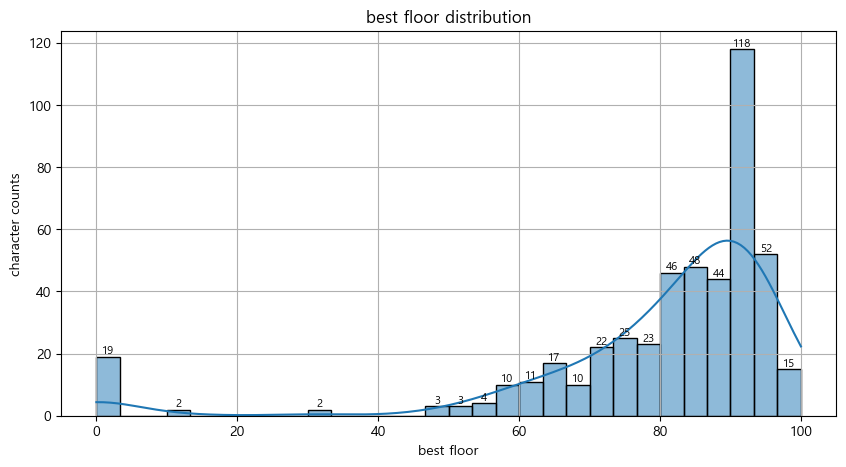

In [94]:
# 도장 최고층수 기본 분포 확인
plt.figure(figsize=(10,5))
ax = sns.histplot(df['dojang_best_floor'], bins=30, kde=True)

# 각 bar에 캐릭터 수 표시
for i in ax.patches:
    count = int(i.get_height())
    if count > 0 :
        ax.annotate(f'{count}', (i.get_x() + i.get_width() / 2, count),
                    ha='center', va='bottom', fontsize=8, rotation=0)
        
plt.title('best floor distribution')
plt.xlabel('best floor')
plt.ylabel('character counts')
plt.grid(True)
plt.show()

In [95]:
# 직업별 도장 최고층수 분포

# 직업별 평균 도장 최고층수 계산 후 시각화

mean_floor_by_class = (
    df.groupby('character_class')['dojang_best_floor']
    .mean()
    .sort_values(ascending=False)
)

# 상위 10개 하위 10개 직업을 시각화 해보기

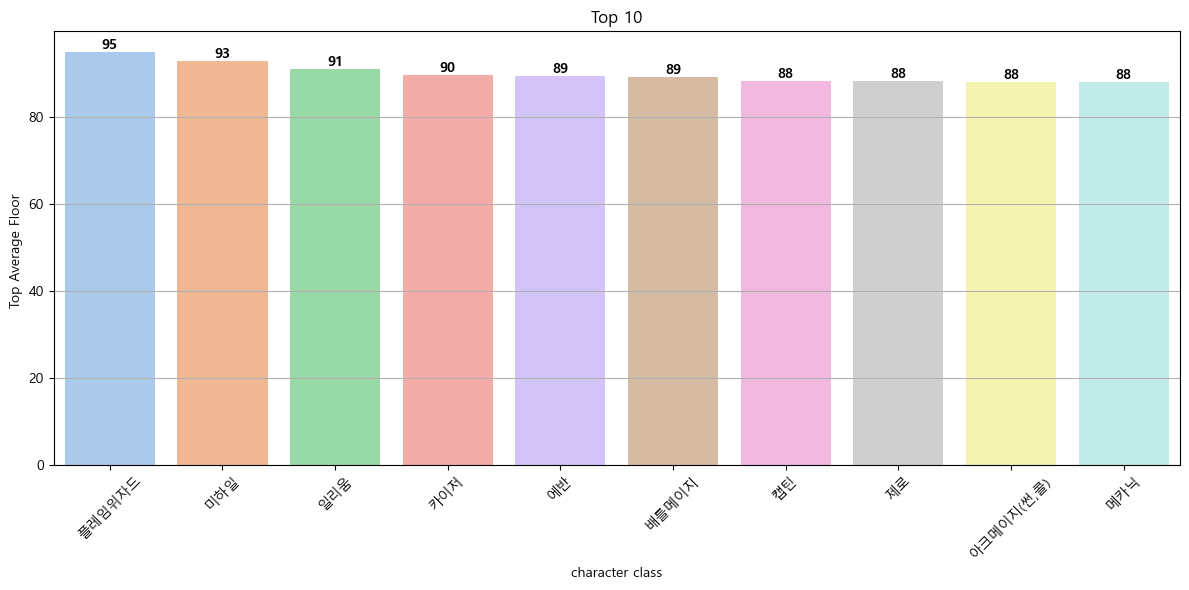

In [96]:
# 우선 상위 10개
palette = sns.color_palette("pastel")
plt.figure(figsize=(12,6))
ax = sns.barplot(x=mean_floor_by_class.head(10).index, y=mean_floor_by_class.head(10).values, palette=palette)

for p in ax.patches:
    value = int(round(p.get_height()))
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.title('Top 10')
plt.xlabel('character class')
plt.ylabel('Top Average Floor ')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

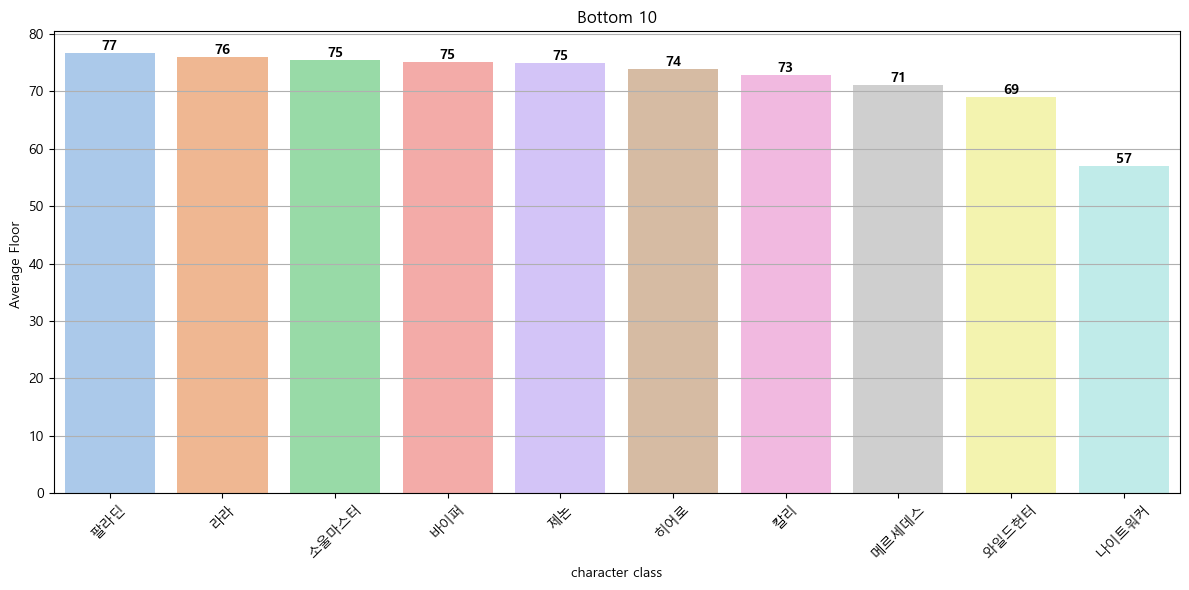

In [97]:
# 하위 10개 직업
# 4번 라인 head만 tail로 바꿔주면 끝

palette = sns.color_palette("pastel")
plt.figure(figsize=(12,6))
ax = sns.barplot(x=mean_floor_by_class.tail(10).index, y=mean_floor_by_class.tail(10).values, palette=palette)

for p in ax.patches:
    value = int(round(p.get_height()))
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.title('Bottom 10')
plt.xlabel('character class')
plt.ylabel('Average Floor ')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [98]:
df = df.drop(['character_date_create','nickname','world_name'], axis=1)
len(df['character_class'].value_counts())

44

In [99]:
# 우선 직업이 무려 44개나 됨 이걸 이후에 머신러닝 feature로 활용하기 위한 작업이 필요함
# 더미변수로 작업할 경우 컬럼이 44개나 더 생기는데, 이는 과적합을 발생시킬 위험이 존재
# 따리서 label encoding을 통해 숫자로 변환한 후, object type으로 변경

# 1. 고유한 직업 리스트 먼저 추출
unique_classes = df['character_class'].drop_duplicates().sort_values().reset_index(drop=True)

# 2. LabelEncoder 적용
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
class_mapping = pd.DataFrame({
    'character_class': unique_classes,
    'character_class_encoded': le.fit_transform(unique_classes)
})

class_mapping.to_csv('./data/class_mapping.csv', index=False)

# 3. 이후 df에 인코딩 값 부여
df = df.merge(class_mapping, on='character_class', how='left')


In [100]:
# 캐릭터 직업(character_class)컬럼 지우기

df = df.drop([
            'character_class','스탠스','점프력','AP 배분 STR', 
            'AP 배분 DEX', 'AP 배분 INT', 'AP 배분 LUK', 
            'AP 배분 HP', 'AP 배분 MP'
            ],axis=1)

In [101]:
df.columns

Index(['character_level', 'character_exp_rate', 'dojang_best_floor',
       'dojang_best_time', 'popularity', '최소 스탯공격력', '최대 스탯공격력', '데미지',
       '보스 몬스터 데미지', '최종 데미지', '방어율 무시', '크리티컬 확률', '크리티컬 데미지', '상태이상 내성',
       '방어력', '이동속도', '스타포스', '아케인포스', '어센틱포스', 'STR', 'DEX', 'INT', 'LUK',
       'HP', 'MP', '아이템 드롭률', '메소 획득량', '버프 지속시간', '공격 속도', '일반 몬스터 데미지',
       '재사용 대기시간 감소 (초)', '재사용 대기시간 감소 (%)', '재사용 대기시간 미적용', '속성 내성 무시',
       '상태이상 추가 데미지', '무기 숙련도', '추가 경험치 획득', '공격력', '마력', '전투력', '소환수 지속시간 증가',
       'force_sum', 'force_mean', 'force_min', 'character_class_encoded'],
      dtype='object')

In [106]:
df['스타포스']

0      470
1      446
2      276
3      291
4      459
      ... 
469    336
470    426
471    404
472    404
473    291
Name: 스타포스, Length: 474, dtype: int64

In [102]:
# Drop columns
# 스탠스 : 고윳값이 하나
# 점프력 : 고윳값이 하나
# AP 배분 능력치 : 자동배분임 도장 순위에는 STR, DEX, INT, LUK 을 중점적으로 보는게 좋을듯

In [105]:
list_int = ['character_level','dojang_best_floor','dojang_best_time','popularity'
            ,'최소 스탯공격력','최대 스탯공격력', '데미지','보스 몬스터 데미지', '최종 데미지'
            ,'방어율 무시', '크리티컬 확률', '크리티컬 데미지','상태이상 내성','방어력', '이동속도'
            ,'스타포스', '아케인포스', '어센틱포스','STR', 'DEX','INT', 'LUK', 'HP', 'MP','아이템 드롭률'
            , '메소 획득량', '버프 지속시간','공격 속도', '일반 몬스터 데미지', '재사용 대기시간 감소 (초)'
            , '재사용 대기시간 감소 (%)', '재사용 대기시간 미적용', '속성 내성 무시', '상태이상 추가 데미지'
            , '무기 숙련도', '추가 경험치 획득', '공격력', '마력', '전투력', '소환수 지속시간 증가', 
            'force_sum', 'force_mean', 'force_min',]